# SMS Spam/Ham Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline  

## Import and explore data

In [2]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data.head(n=10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


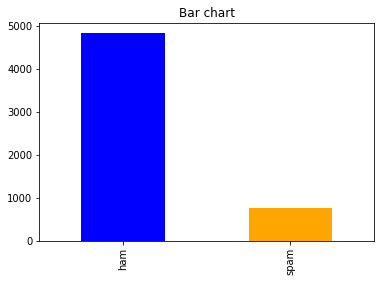

In [3]:
count_Class=pd.value_counts(data["v1"], sort= True)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

In [4]:
count1 = Counter(" ".join(data[data['v1']=='ham']["v2"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(data[data['v1']=='spam']["v2"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

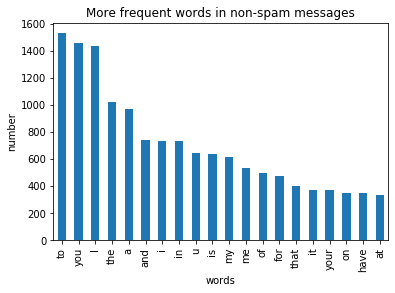

In [5]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

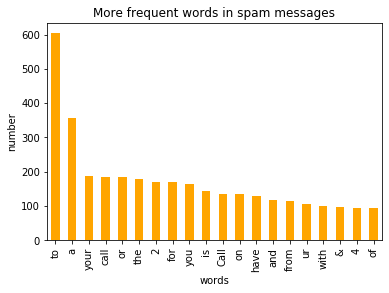

In [6]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

## Remove common words from features

In [7]:
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
X = f.fit_transform(data["v2"])
np.shape(X)

(5572, 8404)

## Split into validation, testing and training datasets

In [8]:
data["v1"]=data["v1"].map({'spam':1,'ham':0})
x_train, X_test, y_train, Y_test = model_selection.train_test_split(X, data['v1'], test_size=0.33, random_state=42)
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(x_train, y_train, test_size=0.5, random_state=42)

print([np.shape(X_train), np.shape(X_val), np.shape(X_test)])
print([np.shape(Y_train), np.shape(Y_val), np.shape(Y_test)])
Y_train.head(n=10)

[(1866, 8404), (1867, 8404), (1839, 8404)]
[(1866,), (1867,), (1839,)]


2293    0
1774    0
4186    0
2798    0
201     0
3514    0
3947    0
449     0
1479    0
2647    0
Name: v1, dtype: int64

## SVM Model

### Determine optimal C value

In [9]:
list_C = np.arange(500, 2000, 100) #100000
score_train = np.zeros(len(list_C))
score_val = np.zeros(len(list_C))
recall_val = np.zeros(len(list_C))
precision_val = np.zeros(len(list_C))
count = 0
for C in list_C:
    svc = svm.SVC(C=C)
    svc.fit(X_train, Y_train)
    score_train[count] = svc.score(X_train, Y_train)
    score_val[count]= svc.score(X_val, Y_val)
    recall_val[count] = metrics.recall_score(Y_val, svc.predict(X_val))
    precision_val[count] = metrics.precision_score(Y_val, svc.predict(X_val))
    count = count + 1 

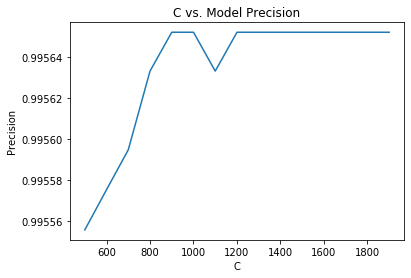

In [10]:
plt.plot(list_C, precision_val)
plt.title('C vs. Model Precision')
plt.xlabel('C')
plt.ylabel('Precision')
plt.show()

In [11]:
matrix = np.matrix(np.c_[list_C, score_train, score_val, recall_val, precision_val])
models = pd.DataFrame(data = matrix, columns = 
             ['C', 'Train Accuracy', 'Val Accuracy', 'Val Recall', 'Val Precision'])
models.round(4).head(n=10)

,C,Train Accuracy,Val Accuracy,Val Recall,Val Precision
0,500.0,0.9936,0.9775,0.8453,0.9956
1,600.0,0.9946,0.9780,0.8491,0.9956
2,700.0,0.9968,0.9786,0.8528,0.9956
3,800.0,0.9968,0.9796,0.8604,0.9956
4,900.0,0.9968,0.9802,0.8642,0.9957
5,1000.0,0.9979,0.9802,0.8642,0.9957
6,1100.0,0.9979,0.9796,0.8604,0.9956
7,1200.0,0.9979,0.9802,0.8642,0.9957
8,1300.0,0.9979,0.9802,0.8642,0.9957
9,1400.0,0.9989,0.9802,0.8642,0.9957


In [12]:
best_index = models['Val Precision'].idxmax()
models.iloc[best_index, :]

C                 900.000000
Train Accuracy      0.996785
Val Accuracy        0.980182
Val Recall          0.864151
Val Precision       0.995652
Name: 4, dtype: float64

### Determine optimal kernel

In [13]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
score_train = np.zeros(len(kernels))
score_val = np.zeros(len(kernels))
recall_val = np.zeros(len(kernels))
precision_val = np.zeros(len(kernels))
count = 0
for kernel in kernels:
    svc = svm.SVC(kernel=kernel, C=900)
    svc.fit(X_train, Y_train)
    score_train[count] = svc.score(X_train, Y_train)
    score_val[count]= svc.score(X_val, Y_val)
    recall_val[count] = metrics.recall_score(Y_val, svc.predict(X_val))
    precision_val[count] = metrics.precision_score(Y_val, svc.predict(X_val))
    count = count + 1 

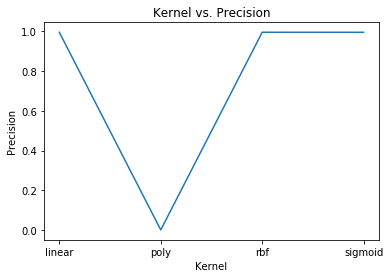

In [14]:
plt.plot(kernels, precision_val)
plt.title('Kernel vs. Precision')
plt.xlabel('Kernel')
plt.ylabel('Precision')
plt.show()

In [15]:
matrix = np.matrix(np.c_[kernels, score_train.round(6), score_val.round(6), recall_val.round(6), precision_val.round(6)])
models = pd.DataFrame(data = matrix, columns = 
             ['Kernel', 'Train Accuracy', 'Val Accuracy', 'Val Recall', 'Val Precision'])
models.head(n=10)

,Kernel,Train Accuracy,Val Accuracy,Val Recall,Val Precision
0,linear,1.0,0.980718,0.867925,0.995671
1,poly,0.876742,0.858061,0.0,0.0
2,rbf,0.996785,0.980182,0.864151,0.995652
3,sigmoid,0.993033,0.975897,0.833962,0.995495


In [16]:
best_index = models['Val Precision'].astype('float').idxmax()
models.iloc[best_index, :]

Kernel              linear
Train Accuracy         1.0
Val Accuracy      0.980718
Val Recall        0.867925
Val Precision     0.995671
Name: 0, dtype: object

### Run optimal parameters on testing dataset

In [17]:
svc_best = svm.SVC(kernel='linear', C=900)
svc_best.fit(X_train, Y_train)
score_train_best = svc_best.score(X_train, Y_train)
score_test = svc_best.score(X_test, Y_test)
recall_test = metrics.recall_score(Y_test, svc_best.predict(X_test))
precision_test = metrics.precision_score(Y_test, svc_best.predict(X_test))

In [18]:
print("Train Accuracy:", score_train_best, "\n")
print("Test Accuracy:", score_test, "\n")
print("Test Recall:", recall_test, "\n")
print("Test Precision:", precision_test, "\n")

Train Accuracy: 1.0 

Test Accuracy: 0.9749864056552474 

Test Recall: 0.8293650793650794 

Test Precision: 0.9858490566037735 



In [19]:
confusion_matrix = metrics.confusion_matrix(Y_test, svc.predict(X_test))
pd.DataFrame(data = confusion_matrix, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1586,1
Actual 1,54,198
